In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [3]:
df = pd.read_csv('absenteeism_data.csv', sep = ';')
df.head(5)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,...,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.0,289,36,69,13,...,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.0,118,13,26,18,...,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.0,179,51,108,18,...,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.0,279,5,5,14,...,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.0,289,36,69,13,...,No,1,2,Yes,No,1,90,172,30,2


# Clustering Analysis

The purpose of this section is to perform different clustering techniques to find interesting patterns among the abseentism data provided. 

The methodologies will include the following algorithsm:
1. K-Means: We will iterate K-means clustering and evaluate results with different number of clusters.
2. Hierarchical: This algorithm provides us with a hierarchy of clusters and represents them in a dendogram. 
3. DBSCAN: To cluster densely packed regions and identify outliers, which can also show us employees with a highly particular absentee behavior.

But first, we will do the obligatory feature selection, based on our previous assesment of the data structure. 


## Step 3.1 Feature Selection

We will select the following features based on an assesment of what type of data are each of the columns in the original dataset. 

In [4]:
#first, take a glimpse at the dataset after preprocessing it
df.dtypes

ID                                   int64
Reason for absence                  object
Month of absence                    object
Day of the week                     object
Seasons                             object
Days since previous absence        float64
Transportation expense               int64
Distance from Residence to Work      int64
Estimated commute time               int64
Service time                        object
Years until retirement               int64
Date of Birth                       object
Disciplinary failure                object
Education                            int64
Number of children                   int64
Social drinker                      object
Social smoker                       object
Number of pets                       int64
Weight                              object
Height                               int64
Body mass index                      int64
Absenteeism time in hours            int64
dtype: object

In [5]:
# Separate between numeric and non nuneric columns

exclude_cols = ['ID'] #columns to drop from features, if they're of no use

numeric_cols = df.select_dtypes(include=[np.number]).columns
feature_names = [col for col in numeric_cols if col not in exclude_cols]
X = df[feature_names].copy() #Dataset to perform clustering analysis

print(f"✓ Selected {len(feature_names)} features for clustering")
print(f"  Features: {', '.join(feature_names[:15])}{'...' if len(feature_names) > 15 else ''}")

✓ Selected 11 features for clustering
  Features: Days since previous absence, Transportation expense, Distance from Residence to Work, Estimated commute time, Years until retirement, Education, Number of children, Number of pets, Height, Body mass index, Absenteeism time in hours


## Step 3.2 Scaling

Since we're dealing with different scales of data (e.g. number of childrem and body mass index) and we will be performing distance based algorithms, we need to perform a scaling function to normalize our data.

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_normalized = scaler.fit_transform(X)

X_prod = pd.DataFrame(X_normalized, columns = X.columns)
X_prod.head(10)


,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Years until retirement,Education,Number of children,Number of pets,Height,Body mass index,Absenteeism time in hours
0,0.0,0.633333,0.659574,0.587156,0.846154,0.000000,0.50,0.125,0.272727,0.578947,0.033333
1,0.0,0.000000,0.170213,0.192661,0.410256,0.000000,0.25,0.000,0.454545,0.631579,0.000000
2,0.0,0.225926,0.978723,0.944954,0.717949,0.000000,0.00,0.000,0.212121,0.631579,0.016667
3,0.0,0.596296,0.000000,0.000000,0.692308,0.000000,0.50,0.000,0.151515,0.263158,0.033333
4,0.0,0.633333,0.659574,0.587156,0.846154,0.000000,0.50,0.125,0.272727,0.578947,0.016667
5,0.0,0.225926,0.978723,0.944954,0.717949,0.000000,0.00,0.000,0.212121,0.631579,0.016667
6,NaN,0.900000,1.000000,1.000000,0.974359,0.000000,0.25,0.500,0.272727,0.421053,0.066667
7,0.0,0.525926,0.957447,0.816514,0.769231,0.000000,1.00,0.000,0.151515,0.210526,0.033333
8,0.0,0.137037,0.148936,0.211009,0.820513,0.000000,0.50,0.000,1.000000,0.315789,0.333333
9,0.0,0.433333,0.127660,0.137615,0.743590,0.666667,0.25,0.125,0.272727,0.526316,0.066667


## Step 3.3 Selecting number of clusters

### 3.3.1 Elbow Method

We will select the number of cluster with the visual method, commonly referred as teh 'Elbow Method'.
To use the elbow method we must calculate the sum of squared errors (SSE) between each data point and the centroid of the cluster to which it was assigned. We do this for all values of k we want to analyze.
Then, we plot the values of k against the respective obtained SSE.

We are looking for the point in which the SSE sharply reduces, meaning the point where adding more clusters doesn't add significant difference. 

In [7]:
ks = range(1, 10)
inertias = []

# provisional fillnan
X_prod.fillna(0, inplace = True)

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(X_prod)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

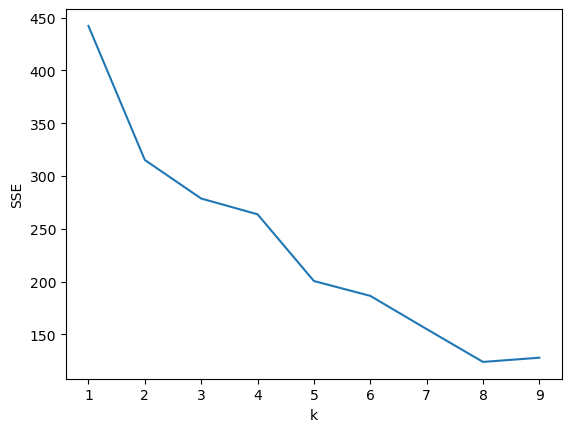

In [8]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot().
plt.plot(ks, inertias)

# define the label for x axis as 'k' using matplotlib.pyplot.xlabel
plt.xlabel('k')
# define the label for y axis as 'SSE' using matplotlib.pyplot.ylabel
plt.ylabel('SSE')
# define the ticks in x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

As we can see from the graph above, we can see a sharp decline in the SSE values until cluster number 3. So we will use this number of cluster.

### 3.3.2 Hierarchical Clustering

We will now apply a second analysis using hierarchical clustering, represented on a tree-shape structure called dendogram. We will compare these results with those above, to be sure about how many number of clusters we should be using. 

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [10]:
# Using Ward Linkage: Minimum variance to minimize the within cluster variance
hclustering = linkage(X_prod, 'ward')

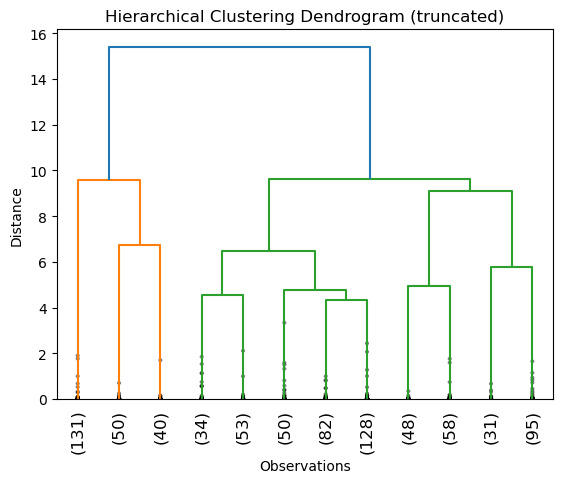

In [11]:
# define the title of the plot
plt.title('Hierarchical Clustering Dendrogram (truncated)')
# define the label for x axis
plt.xlabel('Observations')
# define the label for y axis
plt.ylabel('Distance')

# Draw the dendogram
dendrogram(
    hclustering,
    truncate_mode='lastp',
    p=12,
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.show()

### 3.3.3 Silhoutte Score

We will now apply a third criteria. We will measure the silhouette score for the different number of cluster

We can conclude from this graph, along with the elbow method, that 4 seems to be a good number of clusters!

In [13]:
from sklearn.metrics import silhouette_score

In [14]:
def clusters_scores(X, cluster_algorithm, score_function):
    range_n_clusters = [2, 3, 4, 5, 6]
    scores =[]

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value
        clusterer = cluster_algorithm(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        score_avg = score_function(X, cluster_labels)
        scores.append(score_avg)

        print("For n_clusters =", n_clusters, "The average", score_function.__name__, "is :", score_avg)

    return scores

In [15]:
from sklearn.cluster import KMeans
k_means_silhouette = clusters_scores(X_prod, KMeans, silhouette_score)

For n_clusters = 2 The average silhouette_score is : 0.30809786521026383
For n_clusters = 3 The average silhouette_score is : 0.3200482192010691
For n_clusters = 4 The average silhouette_score is : 0.33758689771792527
For n_clusters = 5 The average silhouette_score is : 0.3095710917167007
For n_clusters = 6 The average silhouette_score is : 0.3848809157652582


In [17]:
def draw_scores(scores):
    plt.figure(figsize=(5, 5))
    plt.plot(range(2, 7), scores,c="#008fd5",label="Silhouette Coefficient")
    plt.title('K-Means Silhouette Score')
    plt.xlabel('Clusters')
    plt.ylabel('Silhouette Score')

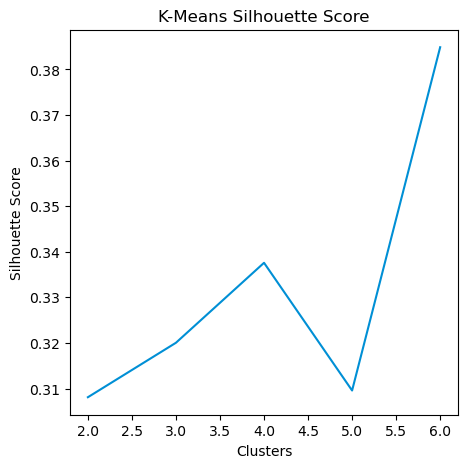

In [18]:
draw_scores(k_means_silhouette)